# Advanced processing

The pynapple package provides a small set of high-level functions that are widely used in systems neuroscience.
- [Discrete correlograms](https://peyrachelab.github.io/pynapple/process.correlograms/)
- [Tuning curves](https://peyrachelab.github.io/pynapple/process.tuning_curves/)
- [Decoding](https://peyrachelab.github.io/pynapple/process.decoding/)
- [PETH](https://peyrachelab.github.io/pynapple/process.perievent/)
- [Randomization](https://peyrachelab.github.io/pynapple/process.randomize/)


This notebook provides few examples with artificial data.

In [1]:
import numpy as np
import pandas as pd
import pynapple as nap
import matplotlib.pyplot as plt

## Discrete correlograms

The function to compute cross-correlogram is [*cross_correlogram*](https://peyrachelab.github.io/pynapple/process.correlograms/#pynapple.process.correlograms.cross_correlogram).


The function is compiled with [numba](https://numba.pydata.org/) to improve performances. This means it only accepts pure numpy arrays as input arguments.

Text(0, 0.5, 'CC')

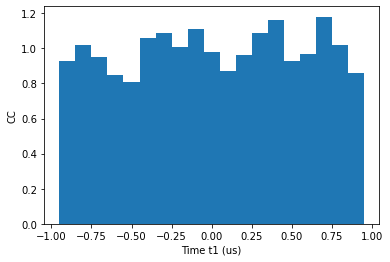

In [2]:
ts1 = nap.Ts(t = np.sort(np.random.uniform(0, 1000, 1000)), time_units = 's')
ts2 = nap.Ts(t = np.sort(np.random.uniform(0, 1000, 1000)), time_units = 's')

ts1_time_array = ts1.as_units('s').index.values
ts2_time_array = ts2.as_units('s').index.values

binsize = 0.1 # second
cc12, xt = nap.cross_correlogram(t1 = ts1_time_array,
                                 t2 = ts2_time_array,
                                 binsize=binsize,
                                 windowsize=1 # second
                                )

plt.figure()
plt.bar(xt, cc12, binsize)
plt.xlabel("Time t1 (us)")
plt.ylabel("CC")


To simplify converting to a numpy.ndarray, pynapple provides wrappers for computing autocorrelogram and crosscorrelogram for TsGroup. The function is then called for each unit or each pairs of units. It returns directly a pandas.DataFrame holding all the correlograms. In this example, autocorrelograms and cross-correlograms are computed for the same TsGroup.

In [3]:
epoch = nap.IntervalSet(start = 0, end = 1000, time_units = 's')
ts_group = nap.TsGroup({0:ts1,1:ts2}, time_support = epoch)

autocorrs = nap.compute_autocorrelogram(group=ts_group,                                         
                                        binsize=100, # ms
                                        windowsize=1000, # ms                                        
                                        time_units='ms',
                                        ep=epoch
                                       )
crosscorrs = nap.compute_crosscorrelogram(group=ts_group,                                        
                                        binsize=100, # ms
                                        windowsize=1000, # ms                                        
                                        time_units='ms'
                                       )

print(autocorrs, '\n')
print(crosscorrs, '\n')


         0     1
-0.9  0.93  0.96
-0.8  1.15  1.01
-0.7  0.95  1.07
-0.6  1.09  0.78
-0.5  1.11  0.89
-0.4  0.88  1.10
-0.3  1.00  1.05
-0.2  0.97  0.93
-0.1  0.99  1.09
 0.0  0.00  0.00
 0.1  0.99  1.09
 0.2  0.97  0.93
 0.3  1.00  1.05
 0.4  0.88  1.10
 0.5  1.11  0.89
 0.6  1.09  0.78
 0.7  0.95  1.07
 0.8  1.15  1.01
 0.9  0.93  0.96 

         0
         1
-0.9  0.93
-0.8  1.02
-0.7  0.95
-0.6  0.85
-0.5  0.81
-0.4  1.06
-0.3  1.09
-0.2  1.01
-0.1  1.11
 0.0  0.98
 0.1  0.87
 0.2  0.96
 0.3  1.09
 0.4  1.16
 0.5  0.93
 0.6  0.97
 0.7  1.18
 0.8  1.02
 0.9  0.86 



## Peri-Event Time Histogram (PETH)

A second way to examine the relationship between spkiking and an event (i.e. stimulus) is to compute a PETH. pynapple uses the function _compute_perievent_ to center spike time around the timestamps of an event within a given window.

In [4]:
stim = nap.Tsd(t = np.sort(np.random.uniform(0, 1000, 10)), 
               d = np.random.rand(10),
               time_units = 's')

peth0 = nap.compute_perievent(ts1, stim, minmax = (-1, 1), time_unit = 's')

print(peth0)

  Index    Freq. (Hz)    ref_times
-------  ------------  -----------
      0         nan        297.474
      1           1.5      458.283
      2           1.5      478.343
      3           1        565.465
      4           1        580.24
      5           1        628.165
      6           1        730.55
      7         nan        837.449
      8           1        932.426
      9         nan        986.733


/home/guillaume/pynapple/pynapple/core/time_series.py:130: RuntimeWarning: invalid value encountered in double_scalars
  self.rate = len(t)/self.time_support.tot_length('s')
/home/guillaume/pynapple/pynapple/core/time_series.py:130: RuntimeWarning: invalid value encountered in double_scalars
  self.rate = len(t)/self.time_support.tot_length('s')
/home/guillaume/pynapple/pynapple/core/time_series.py:130: RuntimeWarning: invalid value encountered in double_scalars
  self.rate = len(t)/self.time_support.tot_length('s')
/home/guillaume/pynapple/pynapple/core/time_series.py:130: RuntimeWarning: invalid value encountered in double_scalars
  self.rate = len(t)/self.time_support.tot_length('s')
/home/guillaume/pynapple/pynapple/core/time_series.py:130: RuntimeWarning: invalid value encountered in double_scalars
  self.rate = len(t)/self.time_support.tot_length('s')
/home/guillaume/pynapple/pynapple/core/time_series.py:130: RuntimeWarning: invalid value encountered in double_scalars
  self.rate

It is then easy to create a raster plot around the times of the stimulation event by calling the _fillna_ function of pandas.

Text(0.5, 0, 'Time from stim (s)')

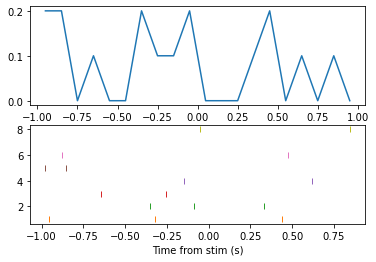

In [5]:
plt.figure()
plt.subplot(211)
plt.plot(peth0.count(0.1, time_units = 's').mean(1))
plt.subplot(212)
for stim_index in peth0.keys():
    plt.plot(peth0[stim_index].as_units('s').fillna(stim_index), '|')
plt.xlabel("Time from stim (s)")

The same function can be applied to a group of neurons.

In [6]:
pethall = nap.compute_perievent(ts_group, stim, minmax = (-1, 1), time_unit = 's')

print(pethall[0])
print(pethall[1])

  Index    Freq. (Hz)    ref_times
-------  ------------  -----------
      0         nan        297.474
      1           1.5      458.283
      2           1.5      478.343
      3           1        565.465
      4           1        580.24
      5           1        628.165
      6           1        730.55
      7         nan        837.449
      8           1        932.426
      9         nan        986.733
  Index    Freq. (Hz)    ref_times
-------  ------------  -----------
      0           3        297.474
      1           0.5      458.283
      2           1        478.343
      3           0.5      565.465
      4           1.5      580.24
      5           0.5      628.165
      6           2.5      730.55
      7           0.5      837.449
      8           2        932.426
      9           1        986.733


/home/guillaume/pynapple/pynapple/core/time_series.py:130: RuntimeWarning: invalid value encountered in double_scalars
  self.rate = len(t)/self.time_support.tot_length('s')
/home/guillaume/pynapple/pynapple/core/time_series.py:130: RuntimeWarning: invalid value encountered in double_scalars
  self.rate = len(t)/self.time_support.tot_length('s')
/home/guillaume/pynapple/pynapple/core/time_series.py:130: RuntimeWarning: invalid value encountered in double_scalars
  self.rate = len(t)/self.time_support.tot_length('s')
/home/guillaume/pynapple/pynapple/core/time_series.py:130: RuntimeWarning: invalid value encountered in double_scalars
  self.rate = len(t)/self.time_support.tot_length('s')
/home/guillaume/pynapple/pynapple/core/time_series.py:130: RuntimeWarning: invalid value encountered in double_scalars
  self.rate = len(t)/self.time_support.tot_length('s')
/home/guillaume/pynapple/pynapple/core/time_series.py:130: RuntimeWarning: invalid value encountered in double_scalars
  self.rate

## Tuning curves

At time of writing, pynapple can compute 1 dimension tuning curves (for example firing rate as a function of angular direction) and 2 dimension tuning curves ( for example firing rate as a function of position). In both cases, a TsGroup object can be directly passed to the function.

                 a         b
Time (s)                    
0.00      1.000000  0.000000
0.01      0.999950  0.010000
0.02      0.999800  0.019999
0.03      0.999550  0.029996
0.04      0.999200  0.039989
...            ...       ...
999.95    0.603003  0.797739
999.96    0.594996  0.803729
999.97    0.586929  0.809639
999.98    0.578803  0.815467
999.99    0.570620  0.821214

[100000 rows x 2 columns]


/home/guillaume/pynapple/pynapple/process/tuning_curves.py:139: RuntimeWarning: invalid value encountered in true_divide
  count = count / occupancy


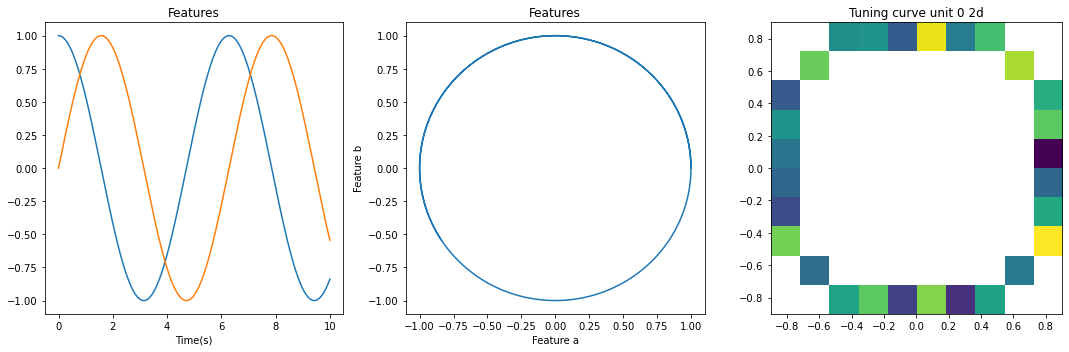

In [7]:
dt = 0.01
features = np.vstack((np.cos(np.arange(0, 1000, dt)),np.sin(np.arange(0,1000,dt)))).T
features = nap.TsdFrame(t = np.arange(0, 1000, dt), d = features, time_units = 's', time_support = epoch, columns=['a', 'b'])

print(features)

tcurves1d = nap.compute_1d_tuning_curves(group=ts_group,
                                         feature=features['a'],
                                         nb_bins=10)

tcurves2d, binsxy = nap.compute_2d_tuning_curves(group=ts_group,
                                                 feature = features,                                                 
                                                 nb_bins=10)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(features.as_units('s').loc[0:10])
plt.title("Features")
plt.xlabel("Time(s)")
plt.subplot(132)
plt.title("Features")
plt.plot(features['a'].as_units('s').loc[0:10], features['b'].as_units('s').loc[0:10])
plt.xlabel("Feature a")
plt.ylabel("Feature b")
plt.subplot(133)
plt.title("Tuning curve unit 0 2d")
plt.imshow(tcurves2d[0], extent=(binsxy[1][0],binsxy[1][-1],binsxy[0][0],binsxy[0][-1]))
plt.tight_layout()
plt.show()

## Decoding

Pynapple supports 1 dimensional and 2 dimensional bayesian decoding. The function returns the decoded feature as well as the probabilities for each timestamps.

First we generate some artificial "place fields" in 2 dimensions based on the features.

In [8]:
#############################################################################################
# This part is just to generate units with a relationship to the features (i.e. "place fields")
times = features.as_units('us').index.values
ft = features.values
alpha = np.arctan2(ft[:,1], ft[:,0])
bins = np.repeat(np.linspace(-np.pi, np.pi, 13)[::,np.newaxis], 2, 1)
bins += np.array([- 2*np.pi/24, 2*np.pi/24])
ts_group = {}
for i in range(12):
    ts = times[(alpha>=bins[i,0]) & (alpha <= bins[i+1,1])]
    ts_group[i] = nap.Ts(ts, time_units = 'us')

ts_group = nap.TsGroup(ts_group, time_support = epoch)

##############################################################################################

import warnings
warnings.filterwarnings('ignore')

tcurves2d, binsxy = nap.compute_2d_tuning_curves(group=ts_group,
                                                 feature=features,                                                 
                                                 nb_bins=10,
                                                 ep=epoch,
                                                 minmax=(-1.,1.,-1.,1.))

Then we plot the "place fields".

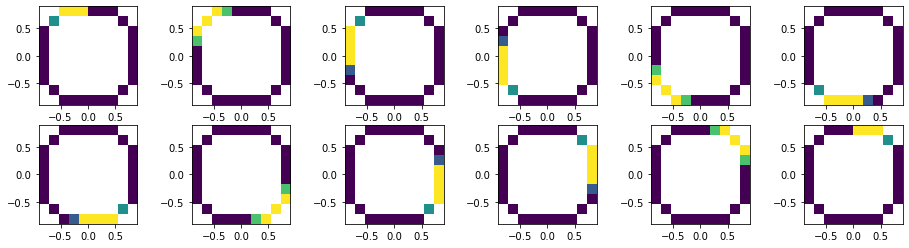

In [9]:
plt.figure(figsize = (16,4))
for i in ts_group.keys():
    plt.subplot(2,6,i+1)
    plt.imshow(tcurves2d[i], extent=(binsxy[1][0],binsxy[1][-1],binsxy[0][0],binsxy[0][-1]))
    plt.xticks()
plt.show()

Then we call the actual decoding function in 2d.

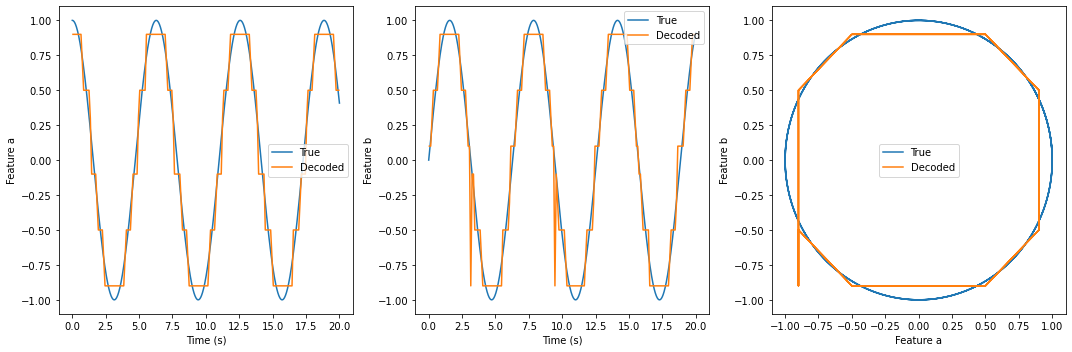

In [10]:
decoded, proba_feature = nap.decode_2d(tuning_curves=tcurves2d, 
                                     group=ts_group,                                   
                                     ep=epoch,
                                     bin_size=0.1, # second
                                     xy=binsxy,
                                    features=features,
                                    )


plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(features['a'].as_units('s').loc[0:20], label = 'True')
plt.plot(decoded['a'].as_units('s').loc[0:20], label = 'Decoded')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Feature a")
plt.subplot(132)
plt.plot(features['b'].as_units('s').loc[0:20], label = 'True')
plt.plot(decoded['b'].as_units('s').loc[0:20], label = 'Decoded')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Feature b")
plt.subplot(133)
plt.plot(features['a'].as_units('s').loc[0:20], features['b'].as_units('s').loc[0:20], label = 'True')
plt.plot(decoded['a'].as_units('s').loc[0:20], decoded['b'].as_units('s').loc[0:20], label = 'Decoded')
plt.xlabel("Feature a")
plt.ylabel("Feature b")
plt.legend()
plt.tight_layout()
plt.show()

## Randomization

Pynapple provides some ready-to-use randomization methods to compute null distributions for statistical testing.
Different methods preserve or destroy different features of the data, here's a brief overview.

`shift_timestamps` shifts all the timestamps in a `Ts` object by the same random amount, wrapping the end of the time support to its beginning. This randomization preserves the temporal structure in the data but destroys the temporal relationships with other quantities (e.g. behavioural data).  
When applied on a `TsGroup` object, each series in the group is shifted independently.
 

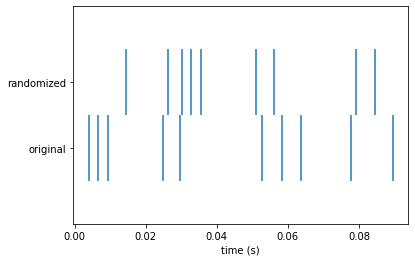

In [14]:
ts = nap.Ts(t = np.sort(np.random.uniform(0, 100, 10)), time_units = 'ms')
rand_ts = nap.shift_timestamps(ts,min_shift=1, max_shift=20)

plt.eventplot([ts.times(),rand_ts.times()])
plt.xlabel('time (s)')
plt.yticks([0,1],['original','randomized']);

`shuffle_ts_intervals` computes the intervals between consecutive timestamps, permutes them, and generates a new set of timestamps with the permuted intervals.
This procedure preserve the distribution of intervals, but not their sequence.

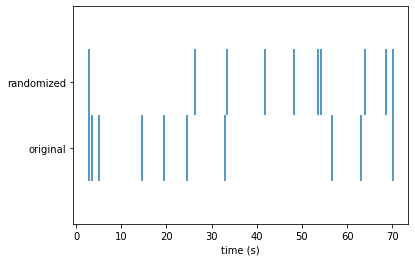

In [15]:
ts = nap.Ts(t = np.sort(np.random.uniform(0, 100, 10)), time_units = 's')
rand_ts = nap.shuffle_ts_intervals(ts)

plt.eventplot([ts.times(),rand_ts.times()])
plt.xlabel('time (s)')
plt.yticks([0,1],['original','randomized']);

`jitter_timestamps` shifts each timestamp in the data of an independent random amount. When applied with a small `max_jitter`, this procedure destroys the fine temporal structure of the data, while preserving structure on longer timescales.

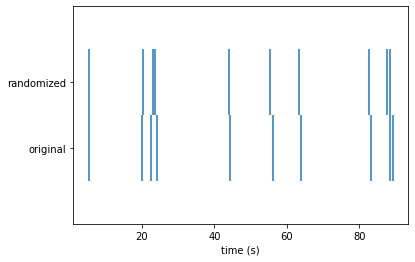

In [18]:
ts = nap.Ts(t = np.sort(np.random.uniform(0, 100, 10)), time_units = 's')
rand_ts = nap.jitter_timestamps(ts,max_jitter=1)

plt.eventplot([ts.times(),rand_ts.times()])
plt.xlabel('time (s)')
plt.yticks([0,1],['original','randomized']);

`resample_timestamps` uniformly re-draws the same number of timestamps in `ts`, in the same time support. This procedures preserve the total number of timestamps, but destroys any other feature of the original data.

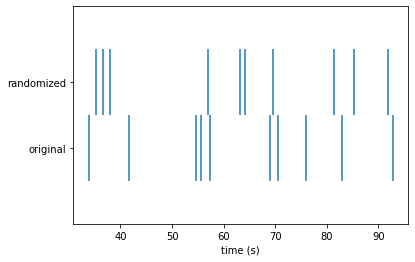

In [19]:
ts = nap.Ts(t = np.sort(np.random.uniform(0, 100, 10)), time_units = 's')
rand_ts = nap.resample_timestamps(ts)

plt.eventplot([ts.times(),rand_ts.times()])
plt.xlabel('time (s)')
plt.yticks([0,1],['original','randomized']);